# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
# !pip install pandas_profiling
# import pandas_profiling as pp

PATH = './'

df_0 = pd.read_csv(PATH+'geo_data_0.csv', index_col='id')
df_1 = pd.read_csv(PATH+'geo_data_1.csv', index_col='id')
df_2 = pd.read_csv(PATH+'geo_data_2.csv', index_col='id')

display(df_0.info())
display(df_1.info())
display(df_2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

In [2]:
display(df_0.describe(include='all'))
display(df_1.describe(include='all'))
display(df_2.describe(include='all'))

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [3]:
# проверим индексы на наличие дубликатов
display(df_0[df_0.index.duplicated(keep=False)].sort_index())
display(df_1[df_1.index.duplicated(keep=False)].sort_index())
display(df_2[df_2.index.duplicated(keep=False)].sort_index())

,f0,f1,f2,product
id,,,,
74z30,1.084962,-0.312358,6.990771,127.643327
74z30,0.741456,0.459229,5.153109,140.771492
A5aEY,-0.180335,0.935548,-2.094773,33.020205
A5aEY,-0.039949,0.156872,0.209861,89.249364
AGS9W,-0.933795,0.116194,-3.655896,19.230453
AGS9W,1.454747,-0.479651,0.683380,126.370504
HZww2,0.755284,0.368511,1.863211,30.681774
HZww2,1.061194,-0.373969,10.430210,158.828695
QcMuo,0.635635,-0.473422,0.862670,64.578675


,f0,f1,f2,product
id,,,,
5ltQ6,-3.435401,-12.296043,1.999796,57.085625
5ltQ6,18.213839,2.191999,3.993869,107.813044
LHZR0,11.170835,-1.945066,3.002872,80.859783
LHZR0,-8.989672,-4.286607,2.009139,57.085625
bfPNe,-9.494442,-5.463692,4.006042,110.992147
bfPNe,-6.202799,-4.820045,2.995107,84.038886
wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
wt4Uk,10.259972,-9.376355,4.994297,134.766305


,f0,f1,f2,product
id,,,,
KUPhW,0.231846,-1.698941,4.990775,11.716299
KUPhW,1.211150,3.176408,5.543540,132.831802
VF7Jo,2.122656,-0.858275,5.746001,181.716817
VF7Jo,-0.883115,0.560537,0.723601,136.233420
Vcm5J,-1.229484,-2.439204,1.222909,137.968290
Vcm5J,2.587702,1.986875,2.482245,92.327572
xCHr8,1.633027,0.368135,-2.378367,6.120525
xCHr8,-0.847066,2.101796,5.597130,184.388641


Как несложно заметить - в каждом из датасетов существуют дубликаты "уникальных" идентификаторов скважин. Но данные дубликаты несколько необычны в том смысле, что целевой признак у них не идентичен (как и все остальное). Можно предположить, что это ошибки именно в задублированном id. В любом случае - подобных строк немного и реальное влияние на конечный результат будет несущественнен вне зависимости от того, как поступить с данной аномалией. В данном конкретном случае - дубликаты в датасете были оставлены (так как id не будет учавствовать при обучении модели).

<AxesSubplot: >

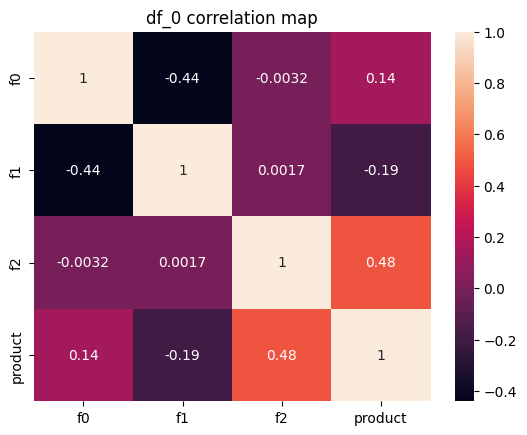

<AxesSubplot: >

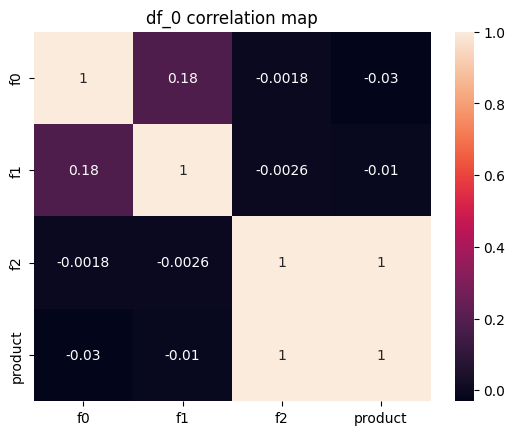

<AxesSubplot: >

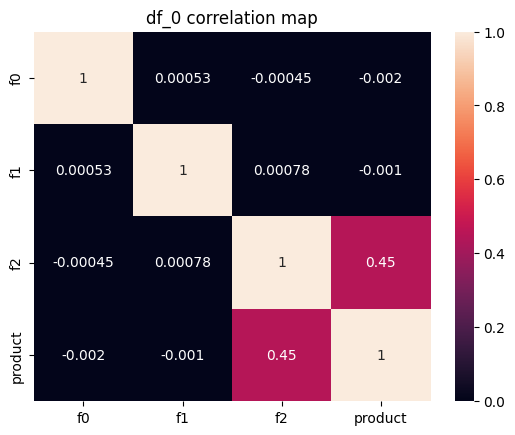

In [4]:
display(sns.heatmap(df_0.corr(), annot=True))
plt.title('df_0 correlation map')
plt.show()

display(sns.heatmap(df_1.corr(), annot=True))
plt.title('df_0 correlation map')
plt.show()

display(sns.heatmap(df_2.corr(), annot=True))
plt.title('df_0 correlation map')
plt.show()

Примечательно, что в датасетах 0 и 2 целевой признак имеет высокую степень корреляции с признаком f2. При этом в датасете 1 - корреляция достигает максимальных значений. Полагаю линейная модель должна сработать весьма неплохо, или очень близко к этому.

## Обучение и проверка модели

In [5]:
REGIONS_N = 3
DATA_MODELS = {}

DATA_MODELS['region_0'] = {}
DATA_MODELS['region_0']['df'] = df_0
DATA_MODELS['region_1'] = {}
DATA_MODELS['region_1']['df'] = df_1
DATA_MODELS['region_2'] = {}
DATA_MODELS['region_2']['df'] = df_2

for region_n in range(REGIONS_N):
    region = f'region_{region_n}'
    data = DATA_MODELS[region]['df']
#     X = data.drop('product', axis=1)
    X = data['f2'].to_frame()
    y = data['product']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)
    
# видимо, обезличенные параметры отнормированны,
# поэтому применение скейлера не оказывает существенного влияния на результат

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    DATA_MODELS[region]['scaler'] = scaler
    
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    score = mean_squared_error(y_val, preds, squared=False) # RMSE score
    DATA_MODELS[region]['model'] = model
    DATA_MODELS[region]['preds'] = pd.Series(preds) # по умолчанию - np.array без индексов
    DATA_MODELS[region]['y_val'] = y_val.reset_index(drop=True) # по умолчанию индексы - индексы скважин
    DATA_MODELS[region]['score'] = score

In [6]:
print(DATA_MODELS.keys())
print(DATA_MODELS['region_0'].keys())
print()
for i in DATA_MODELS:
    print(i, 'coefs', DATA_MODELS[i]['model'].coef_)
    print(i, 'intercept', DATA_MODELS[i]['model'].intercept_)
    print(i, 'score', DATA_MODELS[i]['score'])
    print()

dict_keys(['region_0', 'region_1', 'region_2'])
dict_keys(['df', 'scaler', 'model', 'preds', 'y_val', 'score'])

region_0 coefs [21.42120431]
region_0 intercept 92.55801454305207
region_0 score 38.75148536710881

region_1 coefs [45.91627939]
region_1 intercept 68.85820641759084
region_1 score 1.595175235376751

region_2 coefs [19.98785786]
region_2 intercept 94.9496669760935
region_2 score 40.145281273044134



In [7]:
data_to_show = ['preds', 'score']
mean_value = {}

for param in data_to_show:
    param_list = []
    for i in DATA_MODELS:
        param_list.append(DATA_MODELS[i][param].mean())
        mean_value[param] = pd.Series(param_list).mean()
        print(i, param, DATA_MODELS[i][param].mean())
    print('mean among', param, mean_value[param])

region_0 preds 92.34937175741717
region_1 preds 68.72121729260876
region_2 preds 94.7711306999486
mean among preds 85.28057324999152
region_0 score 38.75148536710881
region_1 score 1.595175235376751
region_2 score 40.145281273044134
mean among score 26.830647291843235


Мы можем заметить, что модели, обученные на датасетах 0 и 2 демонстрируют значительно большее значение параметра ошибки RMSE. Также несколько настораживает, что у моделей, обученных на датасетах 0 и 2 - весьма значительные значения свободного члена. Также отметим, что значения коэффициентов достаточно разнятся между моделями.

## Подготовка к расчёту прибыли

In [8]:
BUDGET = 1e10
PRICE_PER_UNIT = 45e4
NEED_UNITS = BUDGET/PRICE_PER_UNIT
BEST_WELLS_N = 200
print(f'Необходимый средний объем скважин для достижения безубыточности - {NEED_UNITS/BEST_WELLS_N:.2f}')

for i in DATA_MODELS:
    mean = DATA_MODELS[i]['preds'].mean()
    print(f'Средний прогнозный объем скважин в - {i}', round(mean, 2))

Необходимый средний объем скважин для достижения безубыточности - 111.11
Средний прогнозный объем скважин в - region_0 92.35
Средний прогнозный объем скважин в - region_1 68.72
Средний прогнозный объем скважин в - region_2 94.77


Как ни странно, но чтобы достигнуть уровня безубыточности, нам необходимо показать лучшую результативность, чем дамми-модель, которая предсказывала бы всегда среднее значение.

## Расчёт прибыли и рисков 

In [9]:
RANDOM_STATE = np.random.RandomState(42)

def revenue_func(y_val, preds, n_best=200, budget=BUDGET):
    preds_best = preds.sort_values(ascending=False)
    targets_selected = y_val[preds_best.index][:n_best]

    revenue = targets_selected.sum()*PRICE_PER_UNIT
    return revenue - budget

In [10]:
for region in DATA_MODELS.keys():
    y_val = DATA_MODELS[region]['y_val']
    preds = DATA_MODELS[region]['preds']

    values = []
    for i in range(1000):
        # полагаю в данном случае replace не обязателен
        y_val_subsample = y_val.sample(n=500, replace=True, random_state=RANDOM_STATE) 
        preds_subsample = preds[y_val_subsample.index]
        values.append(revenue_func(y_val_subsample, preds_subsample, n_best=200))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)
    DATA_MODELS[region]['lower'] = lower
    DATA_MODELS[region]['higher'] = higher
    DATA_MODELS[region]['mean_profit'] = values.mean()
    DATA_MODELS[region]['risk'] = (values < 0).mean()

In [11]:
for region in DATA_MODELS.keys():
    print(region, f'Доверительный интервал в рамках от {round(DATA_MODELS[region]["lower"], 2)} до {round(DATA_MODELS[region]["higher"], 2)}')
    print(region, f'Средняя прибыль - {round(DATA_MODELS[region]["mean_profit"], 2)}')
    print(region, f'Уровень риска - {DATA_MODELS[region]["risk"]}')
    print()

region_0 Доверительный интервал в рамках от -253315118.36 до 798299388.44
region_0 Средняя прибыль - 278592430.92
region_0 Уровень риска - 0.156

region_1 Доверительный интервал в рамках от 63791499.0 до 914338452.42
region_1 Средняя прибыль - 491589138.24
region_1 Уровень риска - 0.008

region_2 Доверительный интервал в рамках от -117108818.99 до 957355266.09
region_2 Средняя прибыль - 409600579.43
region_2 Уровень риска - 0.071



Единственный регион вообще показавший прибыльность у нижнего рубежа 95% доверительного интервала, высочайшую среднюю прибыль, а также минимальный уровень риска - регион №1. Таким образом, этот регион и является рекомендацией для разработки месторождений.